[Lesson Video Link](https://course.fast.ai/videos/?lesson=2)

[Lesson resources and updates](https://forums.fast.ai/t/lesson-2-official-resources-and-updates/28630)

[Lesson chat](https://forums.fast.ai/t/lesson-2-chat/28722)

[Further discussion thread](https://forums.fast.ai/t/lesson-2-further-discussion/28706)

Note: This is a mirror of the FastAI Lesson 2 Nb. 
Please thank the amazing team behind fast.ai for creating these, I've merely created a mirror of the same here
For complete info on the course, visit course.fast.ai

### Note: The nb displays an error since the num of files downloaded > limit imposed by kaggle. If you fork and run the nb cell by cell, it should run normally, you will have to uncomment each line of code

Note: A few lines have been commented out since it causes "Commit Errors" in kaggle (The steps require manual correction of data which causes the kernel to stop running automatically). 
Please uncomment the lines as you spot them

# Creating your own dataset from Google Images

*by: Francisco Ingham and Jeremy Howard. Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

In [1]:
from fastai import *
from fastai.vision import *

## **Get a list of URLs**

**Search and scroll**

Go to Google Images and search for the images you are interested in. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do.

Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.

It is a good idea to put things you want to exclude into the search query, for instance if you are searching for the Eurasian wolf, "canis lupus lupus", it might be a good idea to exclude other variants:

"canis lupus lupus" -dog -arctos -familiaris -baileyi -occidentalis

You can also limit your results to show only photos by clicking on Tools and selecting Photos from the Type dropdown.

**Download into file**

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

Press CtrlShiftJ in Windows/Linux and CmdOptJ in Mac, and a small window the javascript 'Console' will appear. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. You can do this by running the following commands:

```
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

**Create directory and upload urls file into your server**

Choose an appropriate name for your labeled images. You can run these steps multiple times to grab different labels.

**Note:** You can download the urls locally and upload them to kaggle using:


Here, I have uploaded the urls for 
 - Teddy
 - Grizzly
 - Black 

In [2]:
classes = ['teddys','grizzly','black']

In [3]:
folder = 'black'
file = 'urls_black.txt'

In [4]:
path = Path('data/bears')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)
??path

In [5]:
path="../input/"

In [6]:
download_images(path+file, dest, max_pics=200)
??download_images

In [7]:
folder = 'teddys'
file = 'urls_teddys.txt'

In [8]:
path = Path('data/bears')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [9]:
download_images(path/file, dest, max_pics=200)

FileNotFoundError: [Errno 2] No such file or directory: 'data/bears/urls_teddys.txt'

In [10]:
folder = 'grizzly'
file = 'urls_grizzly.txt'

In [11]:
path = Path('data/bears')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [12]:
download_images(path/file, dest, max_pics=200)

FileNotFoundError: [Errno 2] No such file or directory: 'data/bears/urls_grizzly.txt'

Then we can remove any images that can't be opened:

In [13]:
??verify_images
for c in classes:
     print(c)
     verify_images(path/c, delete=True, max_size=500)

## View data

In [14]:
 np.random.seed(42)
 data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
         ds_tfms=get_transforms(), size=64, num_workers=0).normalize(imagenet_stats)

In [15]:
data.classes

['black']

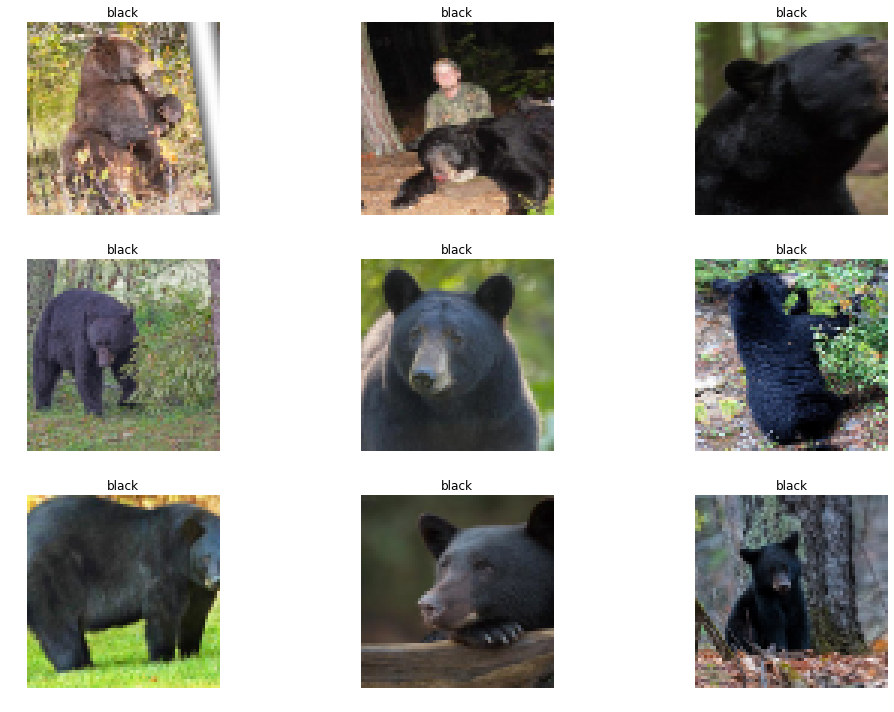

In [16]:
data.show_batch(rows=3, figsize=(15,10))

In [17]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

/opt/conda/lib/python3.6/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 128656396.44it/s]


In [18]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:02
1,0.000000,0.000000,0.000000,00:02
2,0.000000,0.000000,0.000000,00:01
3,0.000000,0.000000,0.000000,00:02


In [19]:
learn.save('stage-1')

In [20]:
learn.unfreeze()

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


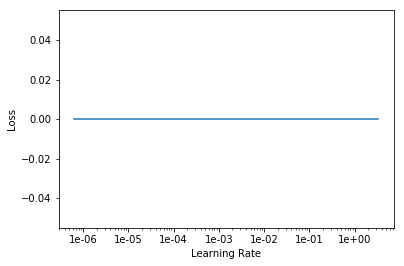

In [22]:
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(2, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:02
1,0.000000,0.000000,0.000000,00:02


In [24]:
learn.save('stage-2')

## Interpretation

In [25]:
learn.load('stage-2');

In [26]:
interp = ClassificationInterpretation.from_learner(learn)

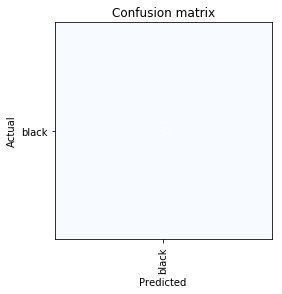

In [27]:
interp.plot_confusion_matrix()

## Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the `ImageCleaner` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

In [28]:
from fastai.widgets import *

First we need to get the file paths from our top_losses. We can do this with `.from_toplosses`. We then feed the top losses indexes and corresponding dataset to `ImageCleaner`.

Notice that the widget will not delete images directly from disk but it will create a new csv file `cleaned.csv` from where you can create a new ImageDataBunch with the corrected labels to continue training your model.

Note: Please Set the Number of images to a number that you'd like to view:
ex: ```n_imgs=100```

In [29]:
ds, idxs = DatasetFormatter().from_toplosses(learn, n_imgs=100)

In [30]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Flag photos for deletion by clicking 'Delete'. Then click 'Next Batch' to delete flagged photos and keep the rest in that row. ImageCleaner will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from top_losses.ImageCleaner(ds, idxs)

You can also find duplicates in your dataset and delete them! To do this, you need to run .from_similars to get the potential duplicates' ids and then run ImageCleaner with duplicates=True. The API works in a similar way as with misclassified images: just choose the ones you want to delete and click 'Next Batch' until there are no more images left.

In [31]:
ds, idxs = DatasetFormatter().from_similars(learn)

Getting activations...


Computing similarities...


Remember to recreate your ImageDataBunch from your cleaned.csv to include the changes you made in your data!

## Putting your model in production
> 
You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [32]:
import fastai


In [33]:
img = open_image(path/'black'/'00000021.jpg')
img

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/data/bears/black/00000021.jpg'

In [34]:
#classes = ['black', 'grizzly', 'teddys']

In [35]:
#data2 = ImageDataBunch.single_from_classes(path, classes, tfms=get_transforms(), size=224).normalize(imagenet_stats)

In [36]:
#learn = create_cnn(data2, models.resnet34).load('stage-2')

In [37]:
#pred_class,pred_idx,outputs = learn.predict(img)
#pred_class

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```

@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
    
    ```
    


(This [example](https://www.starlette.io/) is for the Starlette web app toolkit.)

## Things that can go wrong

- Most of the time things will train fine with the defaults
- There's not much you really need to tune (despite what you've heard!)
- Most likely are
  - Learning rate
  - Number of epochs

### Learning rate (LR) too low

In [38]:
#learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [39]:
#learn.fit_one_cycle(5, max_lr=1e-5)

In [40]:
#learn.recorder.plot_losses()

As well as taking a really long time, it's getting too many looks at each image, so may overfit.

### Too few epochs

In [41]:
#learn = create_cnn(data, models.resnet34, metrics=error_rate, pretrained=False)

In [42]:
#learn.fit_one_cycle(1)

### Too many epochs

In [43]:
# np.random.seed(42)
# data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=32, 
#        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
#                              ),size=224, num_workers=4).normalize(imagenet_stats)

In [44]:
# learn = create_cnn(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
# learn.unfreeze()

In [45]:
# learn.fit_one_cycle(40, slice(1e-6,1e-4))